In [ ]:
!pip install ta

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [112]:
df = pd.read_csv("/kaggle/input/wfc-dataset/WFC.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-14,45.310001,45.790001,44.840000,45.590000,39.616974,16147500
1,2019-06-17,45.580002,46.020000,45.139999,45.270000,39.338902,13420400
2,2019-06-18,45.250000,46.389999,45.060001,46.099998,40.060165,18611100
3,2019-06-19,46.480000,46.750000,45.630001,45.650002,39.669117,17787600
4,2019-06-20,45.849998,45.990002,45.240002,45.860001,39.851589,19205200
...,...,...,...,...,...,...,...
1254,2024-06-07,57.570000,58.680000,57.570000,58.360001,58.360001,14466700
1255,2024-06-10,57.900002,58.130001,57.369999,57.930000,57.930000,12793800
1256,2024-06-11,57.750000,57.750000,56.509998,57.130001,57.130001,19197800
1257,2024-06-12,58.279999,58.450001,57.160000,57.299999,57.299999,16929800


## calculate indicators

In [113]:
def calc_indicators(df):
    ## macd
    data = ta.trend.MACD(df["Close"], 12, 26, 9)
    df["macd"] = data.macd()
    df["macd_signal"] = data.macd_signal()
    
    ## rsi
    data = ta.momentum.RSIIndicator(df["Close"], 14)
    df["rsi"] = data.rsi()
    
    ## obv
    data = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"])
    df["obv"] = data.on_balance_volume()
    
    ## ema
    data = ta.trend.ema_indicator(df["Close"], 12)
    df["ema_12"] = data
    
    ## remove redundancy
    df = df.dropna()
    df = df.drop(["Date", "Open", "High", "Low", "Volume","Adj Close"], axis=1)
    
    ## normalize
    df=(df-df.min())/(df.max()-df.min())
    
    return df
    
df = calc_indicators(df)
df

,Close,macd,macd_signal,rsi,obv,ema_12
33,0.629126,0.226403,0.234067,0.475792,0.534996,0.655924
34,0.638349,0.233535,0.232841,0.511134,0.548269,0.655010
35,0.606796,0.253962,0.236412,0.399383,0.530417,0.649091
36,0.625971,0.261725,0.240998,0.471895,0.543221,0.647209
37,0.598786,0.280356,0.248817,0.387661,0.524896,0.641184
...,...,...,...,...,...,...
1254,0.903398,0.338068,0.292260,0.379110,0.761234,0.951618
1255,0.892961,0.347898,0.304875,0.346710,0.752810,0.946732
1256,0.873544,0.363668,0.318480,0.291364,0.740169,0.939432
1257,0.877670,0.373310,0.331513,0.311206,0.751316,0.933927


# Predict One day Price

## create dataset

In [32]:
data = np.array(df)
data.shape

(1226, 6)

In [33]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_data = data[:int(train_ratio*len(data))]
val_data = data[int(train_ratio*len(data)):int((train_ratio + val_ratio)*len(data))]
test_data = data[int((train_ratio + val_ratio)*len(data)):]

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(858, 6)
(245, 6)
(123, 6)


In [34]:
def createXy(data, period=100):
    params = []
    targets=[]

    for i in range(period, len(data)):
        params.append(data[i-period:i])
        targets.append(data[i, 0])
    return np.array(params), np.array(targets)

X_train, y_train = createXy(train_data)
X_val, y_val = createXy(val_data)
X_test, y_test = createXy(test_data)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(758, 100, 6) (758,)
(145, 100, 6) (145,)
(23, 100, 6) (23,)


## create model

In [35]:
model=Sequential()
model.add(InputLayer(shape=(100, 6)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 50)        │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,851 (202.54 KB)

 Trainable params: 51,851 (202.54 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(optimizer=Adam(), loss=MeanSquaredError())

In [37]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=50)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - loss: 0.0937 - val_loss: 0.0052
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step

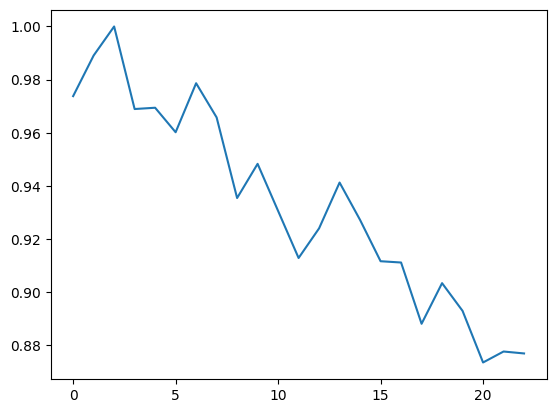

In [38]:
plt.plot(y_test)

In [39]:
test_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


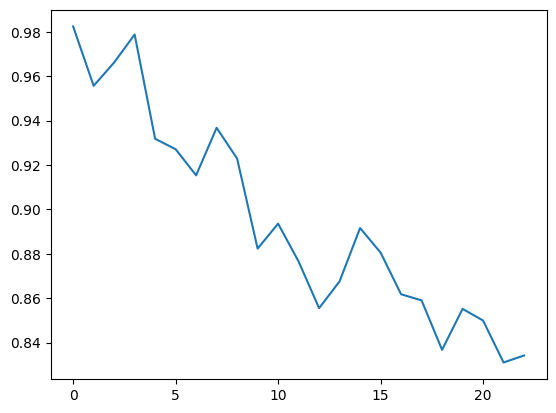

In [40]:
plt.plot(test_pred)

In [105]:
df1 = pd.read_csv("/kaggle/input/jpm-dataset/JPM(1).csv")
df1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-17,109.699997,110.370003,109.059998,109.220001,94.202415,8128600
1,2019-06-18,109.010002,111.410004,108.980003,110.709999,95.487549,11057300
2,2019-06-19,110.820000,111.589996,109.699997,109.910004,94.797554,13126500
3,2019-06-20,110.879997,111.089996,109.029999,110.190002,95.039047,13638000
4,2019-06-21,110.190002,111.669998,109.089996,109.440002,94.392174,27089500
...,...,...,...,...,...,...,...
1254,2024-06-10,199.240005,200.839996,198.440002,199.610001,199.610001,6071200
1255,2024-06-11,197.910004,197.940002,193.600006,194.360001,194.360001,9235300
1256,2024-06-12,196.000000,196.720001,191.309998,191.529999,191.529999,12751300
1257,2024-06-13,192.320007,194.580002,190.880005,193.660004,193.660004,8587800


In [106]:
df1 = calc_indicators(df1)
df1

,Close,macd,macd_signal,rsi,obv,ema_12
33,0.269561,0.268054,0.231919,0.409705,0.785171,0.230202
34,0.242844,0.293435,0.242794,0.254023,0.767636,0.223170
35,0.249682,0.309743,0.255232,0.310450,0.778921,0.218417
36,0.230598,0.333079,0.270530,0.223192,0.759765,0.211054
37,0.245150,0.343073,0.285059,0.331267,0.771823,0.207371
...,...,...,...,...,...,...
1254,0.958810,0.247128,0.208634,0.516358,0.667814,0.994969
1255,0.917064,0.272863,0.219451,0.379458,0.657601,0.988315
1256,0.894561,0.305894,0.235675,0.320154,0.643499,0.978746
1257,0.911498,0.322476,0.252455,0.381033,0.652996,0.973614


In [64]:
data = np.array(df1)
data.shape

(1226, 6)

In [65]:
def createXy(data, period=100):
    params = []
    targets=[]

    for i in range(period, len(data)):
        params.append(data[i-period:i])
        targets.append(data[i, 0])
    return np.array(params), np.array(targets)

X_test, y_test = createXy(data)

print(X_test.shape, y_test.shape)

(1126, 100, 6) (1126,)


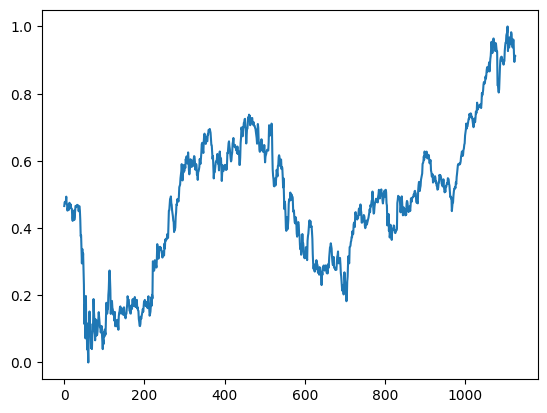

In [66]:
plt.plot(y_test)

In [67]:
test_predict = model.predict(X_test)
test_predict.shape

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


(1126, 1)

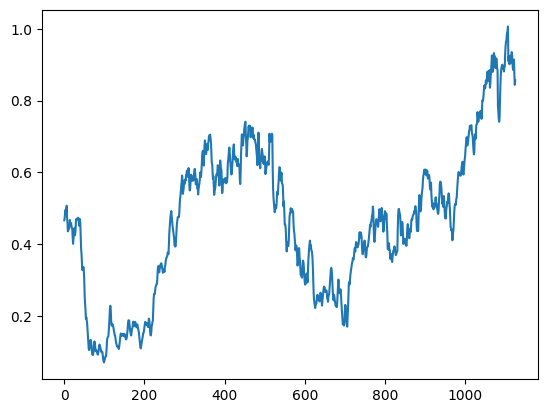

In [68]:
plt.plot(test_predict)

# Predicting future 3 days stock

## create dataset

In [155]:
data = np.array(df)
data.shape

(1226, 6)

In [156]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_data = data[:int(train_ratio*len(data))]
val_data = data[int(train_ratio*len(data)):int((train_ratio + val_ratio)*len(data))]
test_data = data[int((train_ratio + val_ratio)*len(data)):]

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(858, 6)
(245, 6)
(123, 6)


In [157]:
def createXy(data, period=100):
    params = []
    targets=[]

    for i in range(period, len(data)-2):
        params.append(data[i-period:i])
        targets.append(data[i:i+3, 0])
    return np.array(params), np.array(targets)

X_train, y_train = createXy(train_data)
X_val, y_val = createXy(val_data)
X_test, y_test = createXy(test_data)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(756, 100, 6) (756, 3)
(143, 100, 6) (143, 3)
(21, 100, 6) (21, 3)


## create Model

In [158]:
model=Sequential()
model.add(InputLayer(shape=(100, 6)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(3))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 100, 50)        │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,953 (202.94 KB)

 Trainable params: 51,953 (202.94 KB)

 Non-trainable params: 0 (0.00 B)

In [159]:
model.compile(optimizer=Adam(), loss=MeanSquaredError())

In [160]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=50)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - loss: 0.0946 - val_loss: 0.0061
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0068 - val_loss: 0.0040
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step

In [162]:
df1 = pd.read_csv("/kaggle/input/jpm-dataset/JPM(1).csv")
df1 = df1.iloc[:200]
df1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-17,109.699997,110.370003,109.059998,109.220001,94.202415,8128600
1,2019-06-18,109.010002,111.410004,108.980003,110.709999,95.487549,11057300
2,2019-06-19,110.820000,111.589996,109.699997,109.910004,94.797554,13126500
3,2019-06-20,110.879997,111.089996,109.029999,110.190002,95.039047,13638000
4,2019-06-21,110.190002,111.669998,109.089996,109.440002,94.392174,27089500
...,...,...,...,...,...,...,...
195,2020-03-25,89.239998,95.150002,84.540001,91.730003,80.831291,38111700
196,2020-03-26,94.080002,98.570000,93.540001,98.120003,86.462074,29826300
197,2020-03-27,93.190002,94.839996,90.550003,91.129997,80.302574,30041500
198,2020-03-30,90.650002,94.089996,89.300003,93.500000,82.390984,21656900


In [163]:
df1 = calc_indicators(df1)
df1

,Close,macd,macd_signal,rsi,obv,ema_12
33,0.546246,0.162599,0.137485,0.479169,0.307661,0.487288
34,0.492104,0.191636,0.149696,0.297092,0.251151,0.470430
35,0.505962,0.210294,0.163663,0.363086,0.287517,0.459036
36,0.467290,0.236993,0.180843,0.261034,0.225783,0.441386
37,0.496777,0.248426,0.197158,0.387433,0.264644,0.432558
...,...,...,...,...,...,...
195,0.204641,0.911021,1.000000,0.401777,0.258310,0.000000
196,0.307606,0.829260,0.983146,0.481896,0.364615,0.019900
197,0.194973,0.793298,0.961572,0.413579,0.257543,0.013412
198,0.233161,0.746585,0.933805,0.443695,0.334732,0.015831


In [164]:
data1 = np.array(df1)
data1.shape

(167, 6)

In [83]:
init_data1 = data1[:100]
init_data1 = np.expand_dims(init_data1, axis=0)
init_data1.shape

(1, 100, 6)

In [84]:
model.predict(init_data1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


array([[0.47569266, 0.47879392, 0.5020076 ]], dtype=float32)

In [165]:
def create_dataset1(total_data, period, frame):
    params = []
    for i in range(period, len(total_data), frame):
        params.append(total_data[i-period:i])
        
    return np.array(params)

X_test = create_dataset1(data1, 100, 3)
print(X_test.shape)

(23, 100, 6)


In [166]:
pred_data = model.predict(X_test)
pred_data.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


(23, 3)

In [167]:
pred_data = pred_data.flatten()
pred_data.shape

(69,)

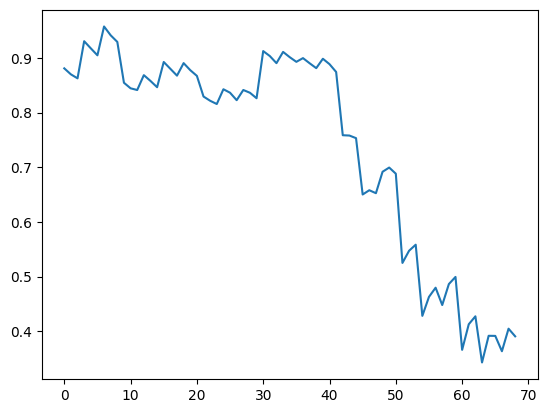

In [168]:
plt.plot(pred_data)

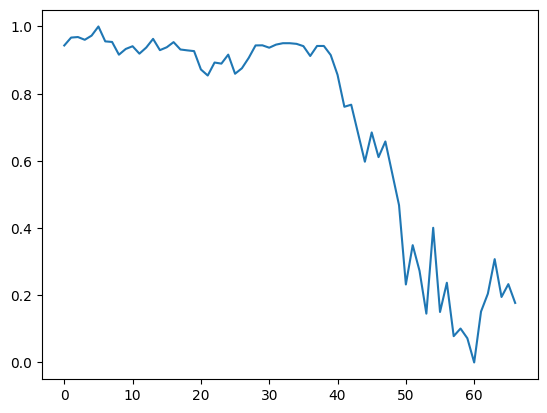

In [171]:
plt.plot(data1[100:, 0])

# Predict 10 days price

## create dataset

In [114]:
data = np.array(df)
data.shape

(1226, 6)

In [116]:
train_ratio = 0.8

train_data = data[:int(train_ratio*len(data))]
val_data = data[int(train_ratio*len(data)):]

print(train_data.shape)
print(val_data.shape)

(980, 6)
(246, 6)


In [117]:
def createXy(data, period=100, frame=3):
    params = []
    targets=[]

    for i in range(period, len(data)-frame+1):
        params.append(data[i-period:i])
        targets.append(data[i:i+frame, 0])
    return np.array(params), np.array(targets)

X_train, y_train = createXy(train_data, 100, 10)
X_val, y_val = createXy(val_data, 100, 10)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(871, 100, 6) (871, 10)
(137, 100, 6) (137, 10)


## create model

In [118]:
model=Sequential()
model.add(InputLayer(shape=(100, 6)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(10))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 100, 50)        │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,310 (204.34 KB)

 Trainable params: 52,310 (204.34 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
model.compile(optimizer=Adam(), loss=MeanSquaredError())

In [120]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=50)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 0.1194 - val_loss: 0.0234
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0079 - val_loss: 0.0200
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0068 - val_loss: 0.0187
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0061 - val_loss: 0.0266
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0051 - val_loss: 0.0330
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0055 - val_loss: 0.0308
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0054 - val_loss: 0.0220
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0053 - val_loss: 0.0250
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0047 - val_loss: 0.0264
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0048 - val_loss: 0.0130
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0046 - val_loss: 0.0166
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step

In [143]:
df1 = pd.read_csv("/kaggle/input/jpm-dataset/JPM(1).csv")
df1 = df1.iloc[:200]
df1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-06-17,109.699997,110.370003,109.059998,109.220001,94.202415,8128600
1,2019-06-18,109.010002,111.410004,108.980003,110.709999,95.487549,11057300
2,2019-06-19,110.820000,111.589996,109.699997,109.910004,94.797554,13126500
3,2019-06-20,110.879997,111.089996,109.029999,110.190002,95.039047,13638000
4,2019-06-21,110.190002,111.669998,109.089996,109.440002,94.392174,27089500
...,...,...,...,...,...,...,...
195,2020-03-25,89.239998,95.150002,84.540001,91.730003,80.831291,38111700
196,2020-03-26,94.080002,98.570000,93.540001,98.120003,86.462074,29826300
197,2020-03-27,93.190002,94.839996,90.550003,91.129997,80.302574,30041500
198,2020-03-30,90.650002,94.089996,89.300003,93.500000,82.390984,21656900


In [144]:
df1 = calc_indicators(df1)
df1

,Close,macd,macd_signal,rsi,obv,ema_12
33,0.546246,0.162599,0.137485,0.479169,0.307661,0.487288
34,0.492104,0.191636,0.149696,0.297092,0.251151,0.470430
35,0.505962,0.210294,0.163663,0.363086,0.287517,0.459036
36,0.467290,0.236993,0.180843,0.261034,0.225783,0.441386
37,0.496777,0.248426,0.197158,0.387433,0.264644,0.432558
...,...,...,...,...,...,...
195,0.204641,0.911021,1.000000,0.401777,0.258310,0.000000
196,0.307606,0.829260,0.983146,0.481896,0.364615,0.019900
197,0.194973,0.793298,0.961572,0.413579,0.257543,0.013412
198,0.233161,0.746585,0.933805,0.443695,0.334732,0.015831


In [145]:
data1 = np.array(df1)
data1.shape

(167, 6)

In [146]:
def create_dataset1(total_data, period, frame):
    params = []
    for i in range(period, len(total_data), frame):
        params.append(total_data[i-period:i])
        
    return np.array(params)

X_test = create_dataset1(data1, 100, 10)
print(X_test.shape)

(7, 100, 6)


In [147]:
pred_data = model.predict(X_test)
pred_data.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


(7, 10)

In [148]:
pred_data = pred_data.flatten()
pred_data.shape

(70,)

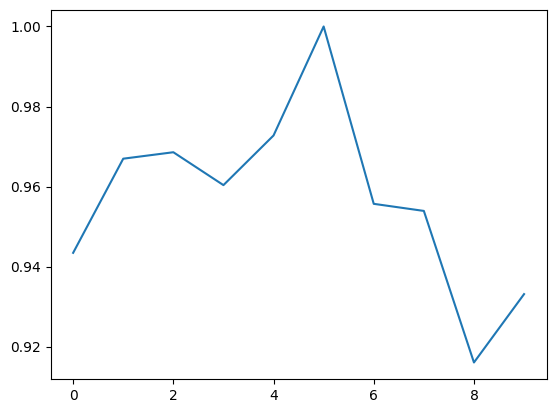

In [153]:
plt.plot(data1[100:110, 0])

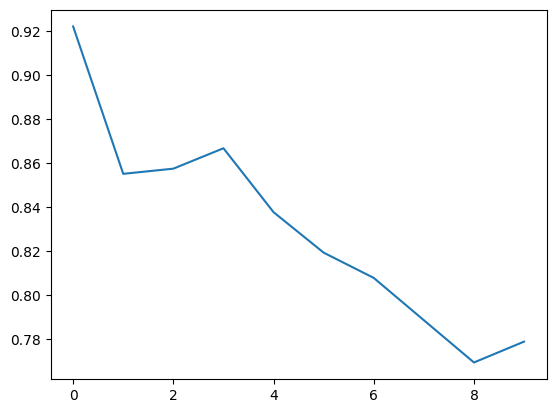

In [154]:
plt.plot(pred_data[:10])